In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## functions to process:

In [3]:
#read image
def read_img():
    print("Enter image name: ")
    image_url = input()
    img = cv.imread(image_url,cv.IMREAD_GRAYSCALE)
    return img

In [4]:
def show_img(img):
    cv.imshow('image',img)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [5]:
#pre processing:
# blurring(reduces noise), thresholding(black & white), dilating(focusing on main image)
def process(img):
    blur = cv.GaussianBlur(img,(5,5),1)
    thresh = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,3)
    inv = cv.bitwise_not(thresh)
    kernel = np.ones((3,3),np.uint8)
    dial = cv.dilate(inv,kernel,iterations=1)
    return dial

In [6]:
#finding the biggest contour i.e sudoku
def biggestCont(contours,perc=0.02):
    biggest = np.array([])
    max_peri = 0
    for c in contours:
        peri = cv.arcLength(c,True)
        approx = cv.approxPolyDP(c,perc*peri,True)
        if peri>max_peri and approx.shape[0]==4:
            biggest = approx
            max_peri = peri
    return biggest

In [7]:
#reorder contour points of the sudoku
def reorder(pts):
    pts = np.reshape(pts,(4,2))
    newPt = np.zeros((4,1,2))
    newPt[0] = pts[np.argmin(pts.sum(axis=1))]
    newPt[3] = pts[np.argmax(pts.sum(axis=1))]
    newPt[1] = pts[np.argmin(np.diff(pts,axis=1))]
    newPt[2] = pts[np.argmax(np.diff(pts,axis=1))]
    return newPt

In [8]:
#remove the sudoku grid(reduces the noise). a little problematic during live stream
def removelines(new,t=3):
    cann = (cv.Canny(new,50,150,0))
    lines = cv.HoughLines(cann,1,np.pi/180,200)
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv.line(new,(x1,y1),(x2,y2),0,t)
    return new

In [9]:
#splitting sudoku into boxes
def split(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

In [10]:
#cropping to reduce the noise (grid lines)
def cropbox(boxes):
    a = np.zeros((81,28,28,1)) #81 boxes of size 28*28
    for i in range(81):
        img = np.array(boxes[i])
        #img = cv.erode(img,np.ones((1,1),np.uint8)) #erode
        img = img[4:img.shape[0]-3,3:img.shape[1]-3] #cropping noisy edges
        img = cv.resize(img,(28,28))
        a[i] = img.reshape((28,28,1))
    return a

In [11]:
#display predictions
def dispNo(no,img = np.zeros((450,450,3)),color=(255,0,255),fs=2):
    h = img.shape[0]//9
    w = img.shape[1]//9
    for i in range(9):
        for j in range(9):
            if no[i*9 + j]!=0:
                cv.putText(img,str(no[i*9 + j]),(int(j*w + 0.1*w),int(i*h + 0.8*h)),cv.FONT_HERSHEY_COMPLEX_SMALL,fs,color,1,cv.LINE_AA)
    return img

### mnist model is used to recognize digits
### sudoku solver code is another file

In [12]:
model = tf.keras.models.load_model('digit.h5')
import import_ipynb
import sudokuSolver

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
importing Jupyter notebook from sudokuSolver.ipynb


In [13]:
width = 450
height = 450

In [14]:
#main
image = read_img()
img = process(image)
contours,hierarchy = cv.findContours(img,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
biggest = biggestCont(contours)
biggest = reorder(biggest)
pts1 = np.float32(np.reshape(biggest,(4,2)))
pts2 = np.float32([[0,0],[width-1,0],[0,height-1],[width-1,height-1]])
M = cv.getPerspectiveTransform(pts1,pts2)
new = cv.warpPerspective(img,M,(width,height))
new = removelines(new,5)
progress = []
progress.append(np.array(cv.resize(cv.cvtColor(image,cv.COLOR_GRAY2BGR),(450,450)),np.uint8))

Enter image name: 
sud.png


In [15]:
boxes = split(new)
a = cropbox(boxes) #### REMEMBER TO NORMALIZE "a" ####
a = tf.keras.utils.normalize(a, axis=1)

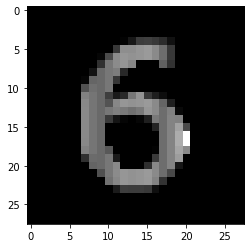

In [16]:
plt.imshow(a[25],cmap=plt.cm.binary_r)

In [17]:
pred = model.predict(a)
pred = pred.argmax(axis=1) * (np.amax(pred,axis=1)>0.5)
progress.append(np.array(dispNo(pred,np.zeros((450,450)),color=(255,0,255)),np.uint8))

In [18]:
pos = (pred==0)*np.ones(81)
pos

array([0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.])

In [19]:
board = pred.reshape((9,9))
try:
    sudokuSolver.solve(board)
except:
    pass
board

array([[5, 3, 4, 6, 7, 8, 9, 1, 2],
       [6, 7, 2, 1, 9, 5, 3, 4, 8],
       [1, 9, 8, 3, 4, 2, 5, 6, 7],
       [8, 5, 9, 7, 6, 1, 4, 2, 3],
       [4, 2, 6, 8, 5, 3, 7, 9, 1],
       [7, 1, 3, 9, 2, 4, 8, 5, 6],
       [9, 6, 1, 5, 3, 7, 2, 8, 4],
       [2, 8, 7, 4, 1, 9, 6, 3, 5],
       [3, 4, 5, 2, 8, 6, 1, 7, 9]])

In [20]:
# pred = model.predict(a)
# pred.argmax(axis=1)[25]

In [21]:
# pred = model.predict(a)
# pred[17]

In [22]:
# pred #due to python refrencing

In [23]:
cv.imshow('image',dispNo(pred,np.zeros((450,450,3))))
cv.imshow('ag',cv.resize(new,(450,450)))
cv.waitKey(0)
cv.destroyAllWindows()

In [24]:
num = np.uint8(pos*pred)
res = dispNo(num,np.zeros((450,450,3)),color=(0,255,0))
# pts2 = np.float32(np.reshape(biggest,(4,2)))(
# pts1 = np.float32([[0,0],[width-1,0],[0,height-1],[width-1,height-1]])
# M = cv.getPerspectiveTransform(pts1,pts2)
# inv = cv.warpPerspective(res,M,(image.shape[1],image.shape[0]))
temp = cv.resize(image,(450,450))
res = np.array(res,np.uint8)
progress.append(res)
# ret,mask = cv.threshold(res,20,255,cv.THRESH_BINARY)
# mask = cv.bitwise_not(mask)
# final = cv.bitwise_and(temp,temp,mask=mask)
final = dispNo(num,cv.cvtColor(temp,cv.COLOR_GRAY2BGR),color=(0,255,0))
progress.append(final)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


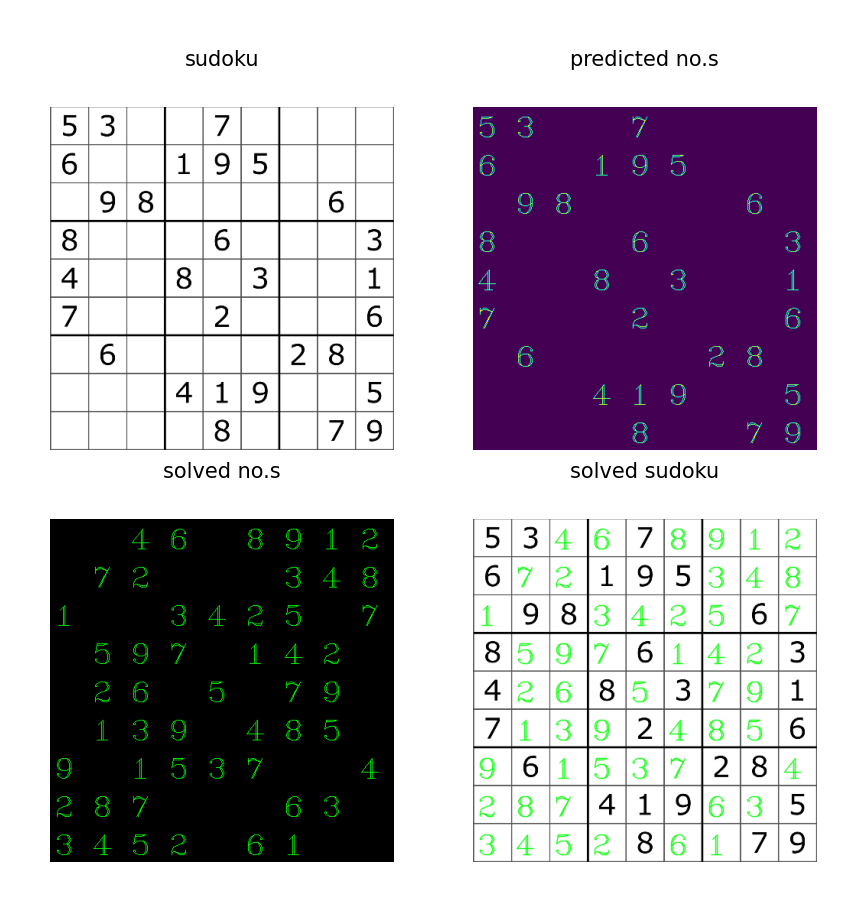

In [25]:
fig = plt.figure(figsize=(2,2),dpi=500)
titles = ['sudoku','predicted no.s','solved no.s','solved sudoku']
for i in range(2):
    for j in range(2):
        fig.add_subplot(2,2,i*2+j+1)
        plt.imshow(progress[i*2+j])
        plt.title(titles[i*2+j],fontdict={'fontsize':3})
        plt.axis('off')
        
fig.show()

In [ ]:
#main live
cap = cv.VideoCapture(0)
if not cap.isOpened():
    print("cannot open cam: exitting")
    exit()

while(True):
    ret,frame = cap.read()
    if not ret:
        print("ret false")
        break
    gray = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
    img = process(gray)
    contours,hierarchy = cv.findContours(img,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    biggest = biggestCont(contours)
    biggest = reorder(biggest)
    pts1 = np.float32(np.reshape(biggest,(4,2)))
    pts2 = np.float32([[0,0],[width-1,0],[0,height-1],[width-1,height-1]])
    M = cv.getPerspectiveTransform(pts1,pts2)
    sud = cv.warpPerspective(img,M,(width,height))
    #new = removelines(sud,5)
    boxes = split(sud)
    a = cropbox(boxes) #### REMEMBER TO NORMALIZE "a" ####
    a = tf.keras.utils.normalize(a, axis=1)
    pred = model.predict(a)
    pred = pred.argmax(axis=1) * (np.amax(pred,axis=1)>0.5)
    cv.imshow('image',dispNo(pred,np.zeros((450,450,3))))
    cv.imshow('preproc',img)
    if cv.waitKey(1)==ord('q'):
        break
    
cap.release()
cv.destroyAllWindows()